# Time series prediction of local crop prices NC

This notebook will test the hypotheses about local (MARS) prices for NC.

* Hypothesis One: Can local price be predicted from the time series itself?
* Hypothesis Two: Can local price be predicted from the time series and CME times series?

Some links:
* [one](https://www.curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
import warnings

# suppress warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import tensorflow as tf
    from tensorflow import keras

# Prepare data
Read the local data and extract STATESVILLE, which is our exemplar for NC.
Use corn because there is more data points then wheat or soy.

Read futures data and extract September corn prices.

Dataframe _data_ contains local and future time series.

In [218]:
CORN = pd.read_csv('corn_local.csv').drop(columns=['Unnamed: 0'])
CORN['date'] = pd.to_datetime(CORN['date'])
SOY = pd.read_csv('soy_local.csv').drop(columns=['Unnamed: 0'])
SOY['date'] = pd.to_datetime(SOY['date'])
WHEAT = pd.read_csv('wheat_local.csv').drop(columns=['Unnamed: 0'])
WHEAT['date'] = pd.to_datetime(WHEAT['date'])

In [81]:
def mkFuturesData(turtle_f, bar_f, month=9):
    '''append turtle and barchart data extract only price for given month'''
    turtle = pd.read_csv(turtle_f)
    bar = pd.read_csv(bar_f)
    df = turtle.append(bar)
    df = df[df['month']==month]
    df = df.drop(columns=['year','month','open','open_net','close_net','open_rel','close_rel','volume','openint', 'day'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.drop_duplicates(subset=['date'])
    df['close'] = df['close'].astype(float)/100.
    df = df.reset_index(drop=True)
    return df

In [88]:
SEP_CORN = mkFuturesData('corn_futures.csv', 'corn_barchart_new.csv', 9)
SEP_SOY = mkFuturesData('soy_futures.csv', 'soybeans_barchart_new.csv', 9)
SEP_WHEAT = mkFuturesData('wheat_futures.csv', 'wheat_barchart_new.csv', 9)

In [7]:
def create_dataset(X, y, time_steps=1):
    """given X and y, return _window_ of length time_steps that has the previous values that _predict_ the y"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [103]:
CORN['location'].unique()

array(['BLADENBORO_F', 'CANDOR_F', 'COFIELD_F', 'LAURINBURG_F',
       'ROSE_HILL_1_F', 'MONROE_F', 'NASHVILLE_F', 'ROARING_RIVER_F',
       'STATESVILLE_F', 'WARSAW_F', 'CRESWELL_E', 'ELIZABETH_CITY_E',
       'NORWOOD_E'], dtype=object)

# Support routines
Skip to next section if you want to see the data & analysis.

In [214]:
def merge(datasets):
    '''joins two datasets.  Each data set must have a date field.
    Exact one dataset (usually the first) has a value field named "price" 
    Output is a new data set with a date field and all the values field in the input sets'''
    _df = datasets[0].copy()
    for d in datasets[1:]:
        _df = _df.merge(d, on='date')
    _df = _df.reset_index(drop=True)
    return _df

In [304]:
def mkModel(data, training_set_size=0.8, time_steps=10):
    '''given a data set that contains columns the are a time series
    returns a model and 4 datasets (X_train, y_train, X_test, y_test)'''
    train_size = int(len(data) * training_set_size)
    train, test = data.iloc[0:train_size], data.iloc[train_size:]
    # print('set size: train {} test {}'.format(len(train), len(test)))
    
    X_train, y_train = create_dataset(train, train.price, time_steps)
    X_test, y_test = create_dataset(test, test.price, time_steps)
    # print('set shapes: {} {}'.format(X_train.shape, y_train.shape))
    
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
      units=30, return_sequences=True,
      input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(keras.layers.LSTM(units=30, return_sequences=True))
    model.add(keras.layers.LSTM(units=30))
    model.add(keras.layers.Dense(units=1))
    model.compile(
      loss='mean_squared_error',
      optimizer=keras.optimizers.Adam(0.001)
    )
    return model, X_train, y_train, X_test, y_test

In [174]:
def fitIt(evaluation, verbose=0):
    history = evaluation['model'].fit(
        evaluation['datasets'][0], # X_train
        evaluation['datasets'][1], # y_train
        epochs=30,
        batch_size=16,
        validation_split=0.1,
        verbose=verbose,
        shuffle=False,
    )

    evaluation['history'] = history

In [179]:
def predictIt(evaluation):
    evaluation['y_predict'] = evaluation['model'].predict(evaluation['datasets'][2])

In [228]:
def showIt(evaluation, which='history', title=''):
    '''plots predicted results three ways.
    _diff_ presents the error (true-predicted).
    _history_ plots the training, the true, and the predicted
    any other string plots the true and predicted values'''
    y_test = evaluation['datasets'][3]
    y_predict = evaluation['y_predict']

    plt.rcParams["figure.figsize"] = (20,10)

    if which == 'diff':
        error = y_predict[:,0] - y_test
        plt.plot(error)
        plt.axhline(0, color='black')
        print('Mean:{:.4f} Var: {:.4f}'.format(error.mean(), error.var()))
    else:
        if which == 'history':
            y_train = evaluation['datasets'][1]

            nan = np.empty(len(y_train))
            nan[:] = np.nan
            y_predict = np.append(nan, y_predict)
            y_test = np.append(nan, y_test)
            plt.plot(y_train, label='history')

        if title:
            print(title)

        plt.plot(y_predict,label='predict')
        plt.plot(y_test,label='true')
        plt.legend()
        plt.show()

# Evaluations
Create a set of _evaluations_.
Each evaluation contains a model and datasets.
Later, we will fit the model and predict results.
The fit is separate from this because it takes a few minutes.

In [316]:
if True:
    crop = 'corn'
    local = CORN
    futures = SEP_CORN
    center = 'STATESVILLE_F'   # the "primary" location

if False:
    crop = 'soy'
    local = SOY
    futures = SEP_SOY
    center = 'ELIZABETH_CITY_E'   # the "primary" location

if False:
    crop = 'wheat'
    local = WHEAT
    futures = SEP_WHEAT
    center = 'STATESVILLE_F'   # the "primary" location


# get all the locations for the crop, remove STATESVILLE_F
locations = list(local['location'].unique())
del locations[locations.index(center)]

data = local[local['location']==center]
data = data.drop(columns=['location'])

evaluations = []

# time series only
this_data = data.drop(columns=['date'])
elements = mkModel(this_data, time_steps=10)
    
evaluation = {'model': elements[0], 'datasets': elements[1:]}
evaluations.append(evaluation)

# add futures data
data = merge([data, futures])
this_data = data.drop(columns=['date'])
elements = mkModel(this_data, time_steps=10)

evaluation = {'model': elements[0], 'datasets': elements[1:]}
evaluations.append(evaluation)

"""
for l in locations:
    new_df = local[local['location']==l].drop(columns=['location']).rename(columns={'price': l})
    data = merge([data, new_df])
    this_data = data.drop(columns=['date'])
    elements = mkModel(this_data)

    evaluation = {'model': elements[0], 'datasets': elements[1:]}
    evaluations.append(evaluation)
"""
Evaluations[crop] = evaluations

In [317]:
corn_model2_50_timesteps = Evaluations['corn'][0:2]

In [320]:
# Evaluations['corn'][0]['model'].summary()
ev = Evaluations['corn'][1]
fitIt(ev, verbose=1)
predictIt(ev)

Train on 3301 samples, validate on 367 samples
Epoch 1/30
3301/3301 [==============================] - 16s 5ms/sample - loss: 1.7347 - val_loss: 8.6300
Epoch 2/30
3301/3301 [==============================] - 4s 1ms/sample - loss: 3.9581 - val_loss: 4.1018
Epoch 3/30
3301/3301 [==============================] - 5s 1ms/sample - loss: 3.0774 - val_loss: 2.7597
Epoch 4/30
3301/3301 [==============================] - 5s 1ms/sample - loss: 4.2175 - val_loss: 2.0621
Epoch 5/30
3301/3301 [==============================] - 5s 1ms/sample - loss: 4.1069 - val_loss: 1.1377
Epoch 6/30
3301/3301 [==============================] - 4s 1ms/sample - loss: 3.7560 - val_loss: 1.3508
Epoch 7/30
3301/3301 [==============================] - 4s 1ms/sample - loss: 2.9174 - val_loss: 3.9585
Epoch 8/30
3301/3301 [==============================] - 4s 1ms/sample - loss: 2.1114 - val_loss: 0.0472
Epoch 9/30
3301/3301 [==============================] - 4s 1ms/sample - loss: 0.7850 - val_loss: 0.0765
Epoch 10/30
3301

## Compare to "yesterday"
Naive, trivial predictor is tomorrow's price will be today's price.

In [273]:
def yesterday(predict, test):
    '''compare predict_i to test_{i-1}'''
    trivial = test[:-1]
    predict = predict[1:]
    true = test[1:]
    e1 = np.abs(predict - true)
    e2 = np.abs(trivial - true)
    error = e2 - e1
    return error

In [322]:
predict, test = Evaluations['corn'][0]['y_predict'][:,0], Evaluations['corn'][0]['datasets'][3]
predict = predict[1:100]
trivial = test[:-1]
true = test[1:100]
df = pd.DataFrame(zip(predict,trivial,true), columns=['predict','trivial', 'true'])
df['perr'] = df['true'] - df['predict']
df['terr'] = df['true'] - df['trivial']
print(np.sum(df['terr'])**2/np.sum(df['perr'])**2)
df['better'] = np.abs(df['perr']) <= np.abs(df['terr'])
print(len(df[df['better']==True]))
df

0.0003183641657248038
19


,predict,trivial,true,perr,terr,better
0,3.935713,4.04,4.03,0.094287,-0.01,False
1,3.936030,4.03,4.04,0.103970,0.01,False
2,3.939520,4.04,4.05,0.110480,0.01,False
3,3.945930,4.05,4.08,0.134070,0.03,False
4,3.959833,4.08,4.09,0.130167,0.01,False
...,...,...,...,...,...,...
94,3.970578,4.02,4.07,0.099422,0.05,False
95,3.968898,4.07,3.91,-0.058898,-0.16,True
96,3.926848,3.91,3.87,-0.056848,-0.04,False
97,3.870095,3.87,3.84,-0.030095,-0.03,False


# Specific tests
end of generalize

These were the first things done.

In [89]:
# merge local and futures price into one DF by date
_df = STATESVILLE.copy()
data = _df.merge(SEP_CORN, on='date').sort_values(['date'])
#data = data.drop(columns=['date'])
#data

In [8]:
# create train and test sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(len(train), len(test))

3678 920


# Test prediction of time series only
Just evaluate STATESVILLE times series

In [37]:
time_steps = 10
X_train, y_train = create_dataset(train.iloc[:,0:1], train.price, time_steps)
X_test, y_test = create_dataset(test.iloc[:,0:1], test.price, time_steps)
print(X_train.shape, y_train.shape)

(3668, 10, 1) (3668,)


In [38]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 3301 samples, validate on 367 samples
Epoch 1/30
3301/3301 [==============================] - 3s 975us/sample - loss: 1.0407 - val_loss: 2.7792
Epoch 2/30
3301/3301 [==============================] - 2s 743us/sample - loss: 1.2215 - val_loss: 2.3605
Epoch 3/30
3301/3301 [==============================] - 3s 911us/sample - loss: 1.0151 - val_loss: 2.6387
Epoch 4/30
3301/3301 [==============================] - 2s 683us/sample - loss: 0.9797 - val_loss: 1.5611
Epoch 5/30
3301/3301 [==============================] - 2s 637us/sample - loss: 0.8015 - val_loss: 2.1152
Epoch 6/30
3301/3301 [==============================] - 2s 668us/sample - loss: 0.7222 - val_loss: 1.1214
Epoch 7/30
3301/3301 [==============================] - 3s 837us/sample - loss: 0.5695 - val_loss: 0.8655
Epoch 8/30
3301/3301 [==============================] - 2s 656us/sample - loss: 0.4497 - val_loss: 0.5827
Epoch 9/30
3301/3301 [==============================] - 2s 704us/sample - loss: 0.3536 - val_loss: 0.4025

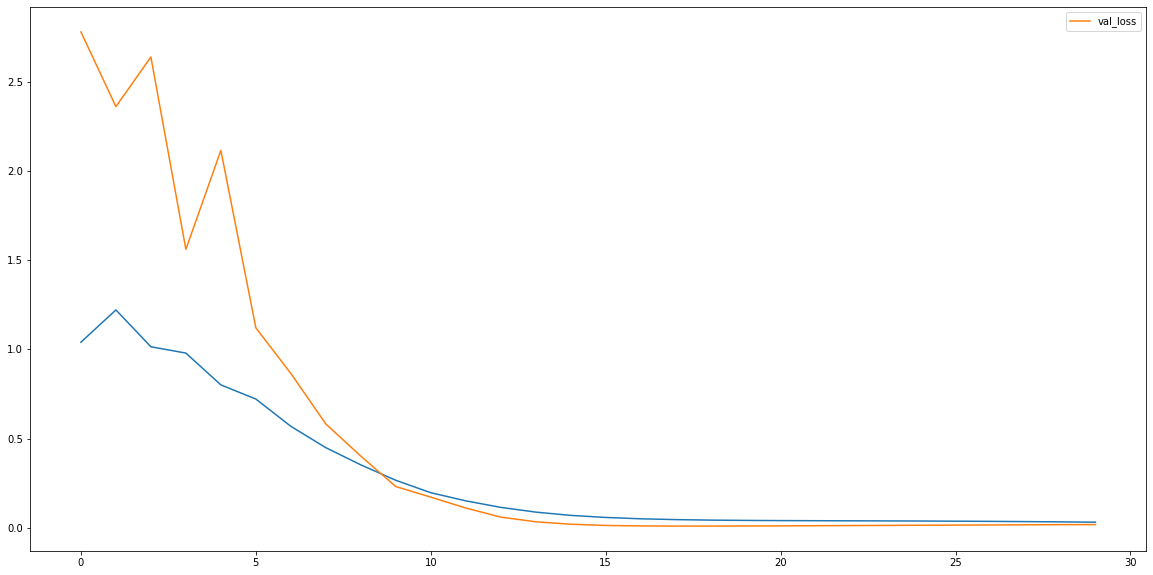

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [42]:
y_predict = model.predict(X_test)

STATESVILLE prediction with history


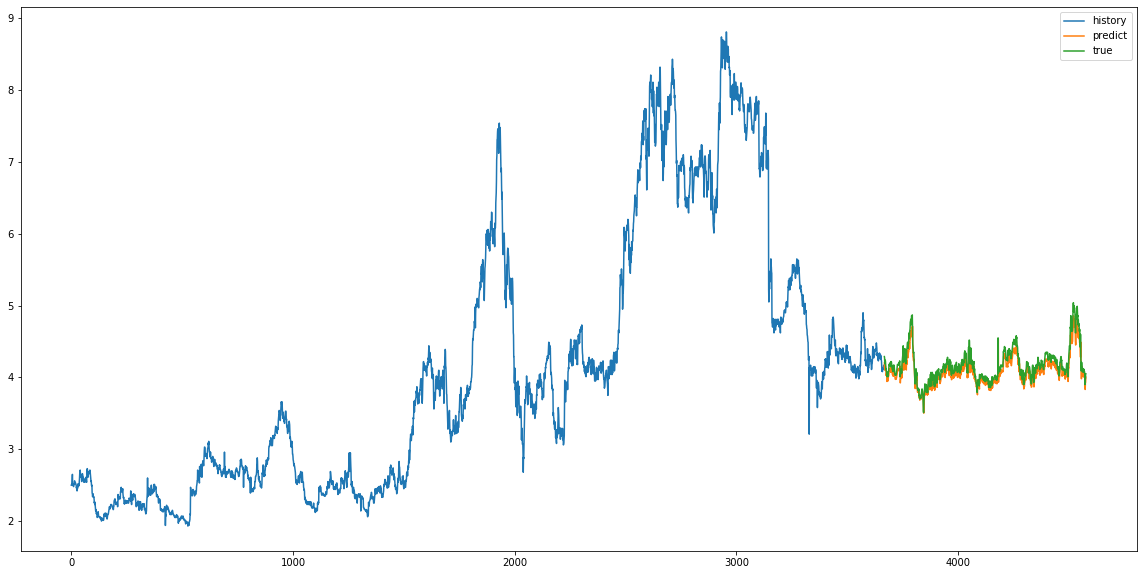

STATESVILLE prediction


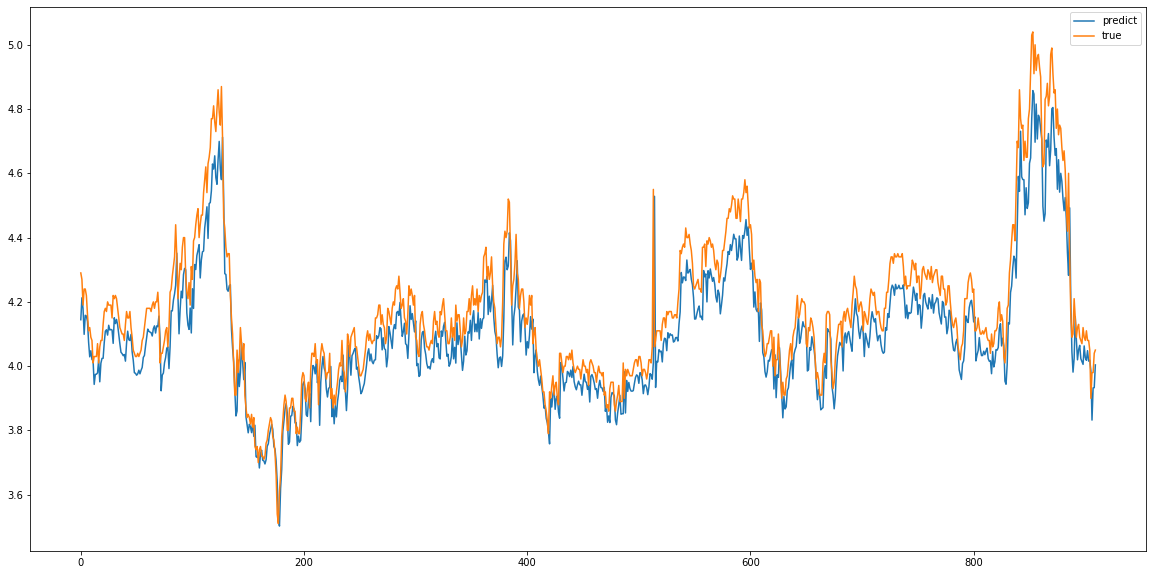

In [43]:
nan = np.empty(len(y_train))
nan[:] = np.nan

plt.rcParams["figure.figsize"] = (20,10)

print("STATESVILLE prediction with history")
plt.plot(y_train, label='history')
plt.plot(np.append(nan, y_predict),label='predict')
plt.plot(np.append(nan, y_test),label='true')
plt.legend()
plt.show()

print("STATESVILLE prediction")
plt.plot(y_predict,label='predict')
plt.plot(y_test,label='true')
plt.legend()
plt.show()

Prediction error : prediction - true


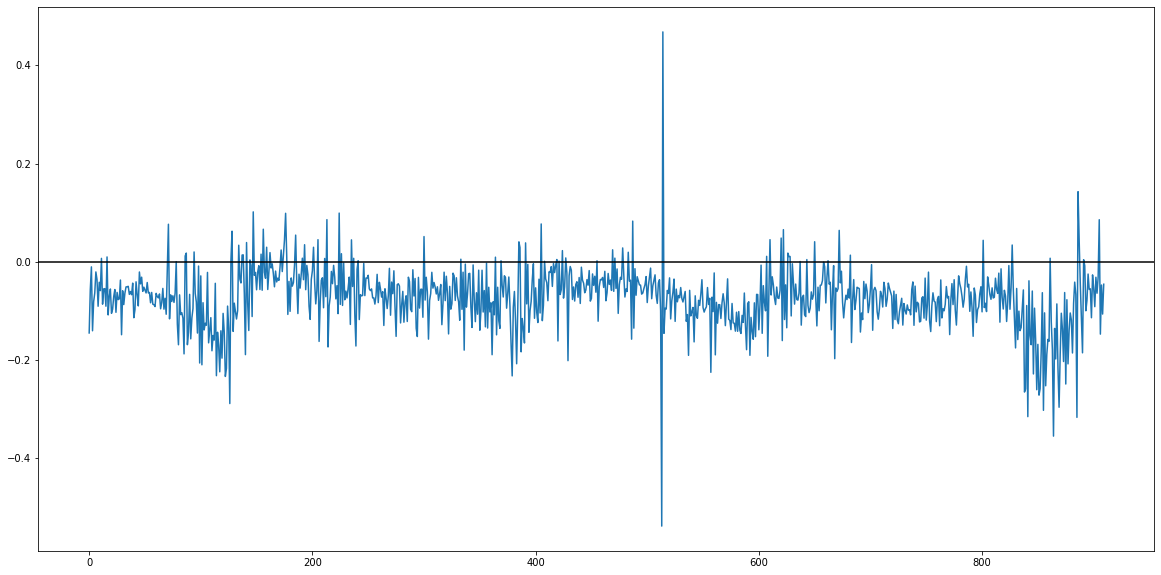

In [66]:
print("Prediction error : prediction - true")
error = y_predict[:,0] - y_test
plt.plot(error)
plt.axhline(0, color='black')

# Test prediciton augmented with futures
Evaluate STATESVILLE with CME data

In [45]:
time_steps = 10
X_train2, y_train2 = create_dataset(train, train.price, time_steps)
X_test2, y_test2 = create_dataset(test, test.price, time_steps)
print(X_train2.shape, y_train2.shape)

(3668, 10, 2) (3668,)


In [46]:
model2 = keras.Sequential()
model2.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train2.shape[1], X_train2.shape[2])
))
model2.add(keras.layers.Dense(units=1))
model2.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [47]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               67072     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 67,201
Trainable params: 67,201
Non-trainable params: 0
_________________________________________________________________


In [48]:
history2 = model2.fit(
    X_train2, y_train2,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 3301 samples, validate on 367 samples
Epoch 1/30
3301/3301 [==============================] - 3s 1ms/sample - loss: 0.8837 - val_loss: 2.0447
Epoch 2/30
3301/3301 [==============================] - 3s 780us/sample - loss: 0.9189 - val_loss: 0.9039
Epoch 3/30
3301/3301 [==============================] - 2s 723us/sample - loss: 0.6108 - val_loss: 1.4372
Epoch 4/30
3301/3301 [==============================] - 2s 723us/sample - loss: 0.5797 - val_loss: 0.7236
Epoch 5/30
3301/3301 [==============================] - 2s 719us/sample - loss: 0.4352 - val_loss: 0.8838
Epoch 6/30
3301/3301 [==============================] - 2s 725us/sample - loss: 0.3747 - val_loss: 0.5163
Epoch 7/30
3301/3301 [==============================] - 2s 719us/sample - loss: 0.2898 - val_loss: 0.4409
Epoch 8/30
3301/3301 [==============================] - 2s 735us/sample - loss: 0.2317 - val_loss: 0.3423
Epoch 9/30
3301/3301 [==============================] - 2s 727us/sample - loss: 0.1998 - val_loss: 0.2576
E

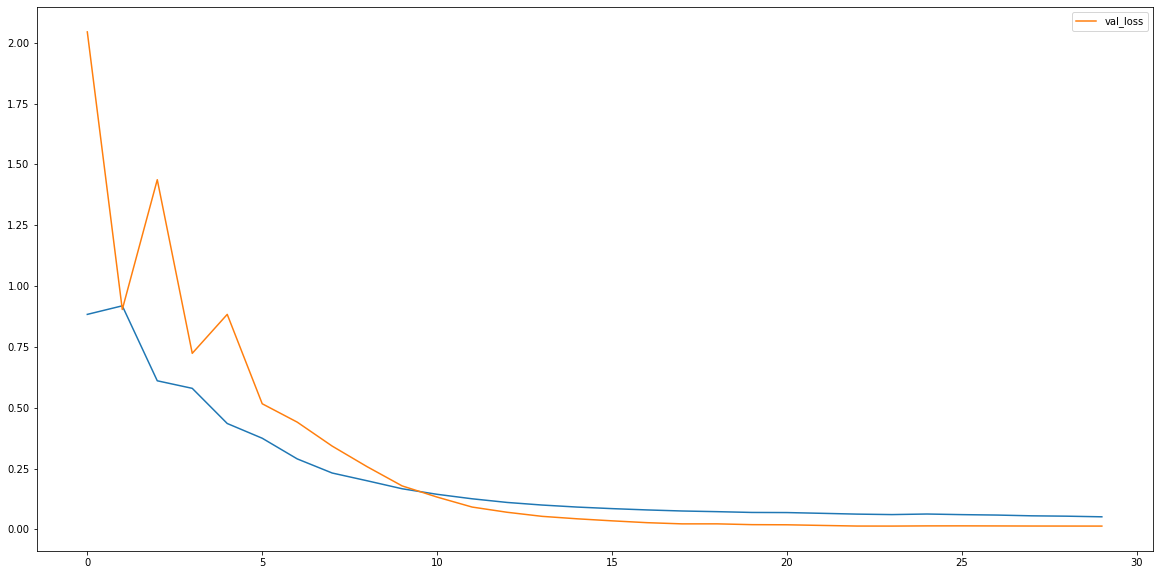

In [49]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'], label='val_loss')
plt.legend()

In [50]:
y_predict2 = model2.predict(X_test2)

STATESVILLE prediction with history


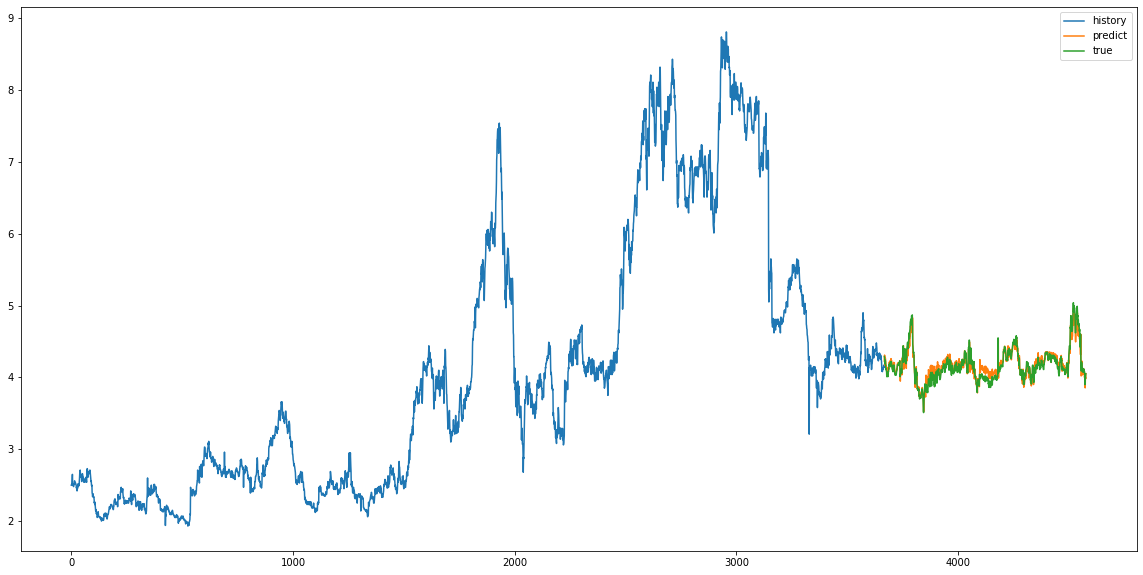

STATESVILLE prediction


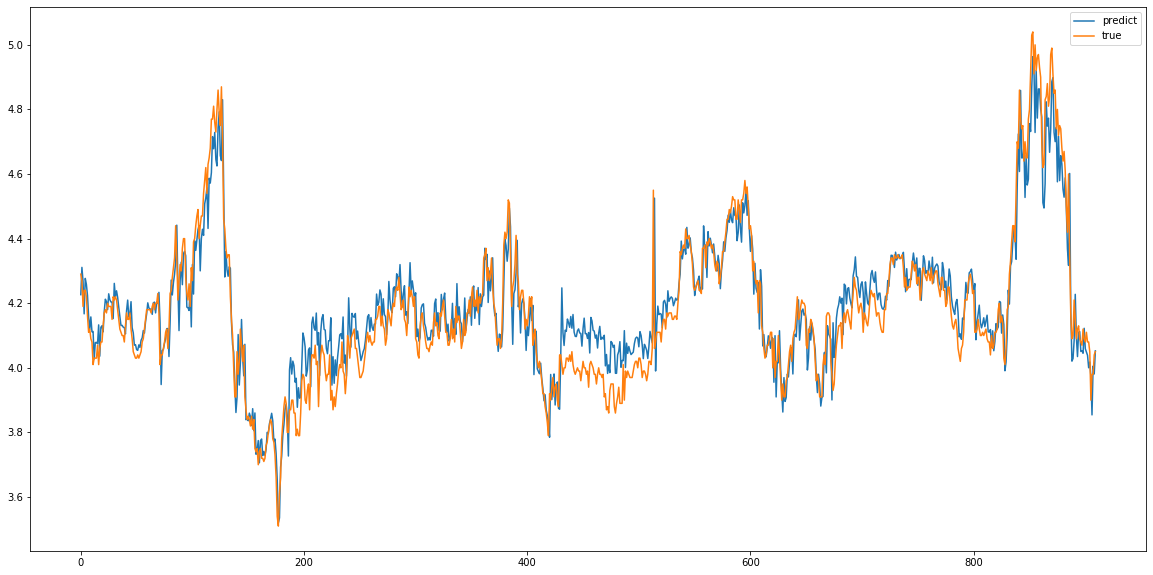

In [51]:
nan = np.empty(len(y_train2))
nan[:] = np.nan

plt.rcParams["figure.figsize"] = (20,10)

print("STATESVILLE prediction with history")
plt.plot(y_train, label='history')
plt.plot(np.append(nan, y_predict2),label='predict')
plt.plot(np.append(nan, y_test2),label='true')
plt.legend()
plt.show()

print("STATESVILLE prediction")
plt.plot(y_predict2,label='predict')
plt.plot(y_test2,label='true')
plt.legend()
plt.show()

Prediction error : prediction - true


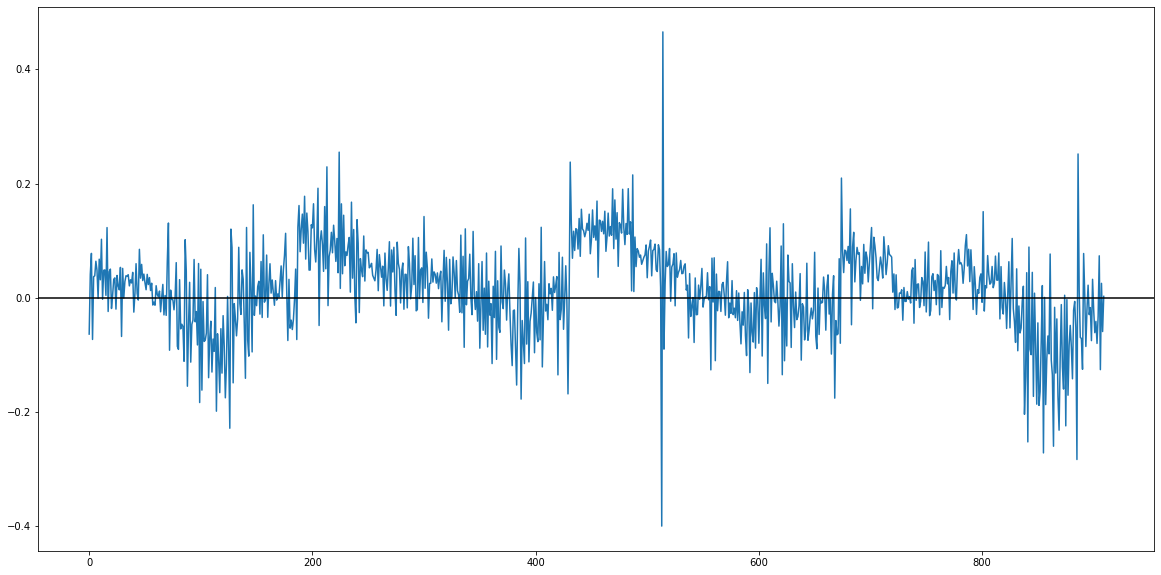

In [64]:
print("Prediction error : prediction - true")
error2 = y_predict2[:,0] - y_test2
plt.plot(error2)
plt.axhline(0, color='black')

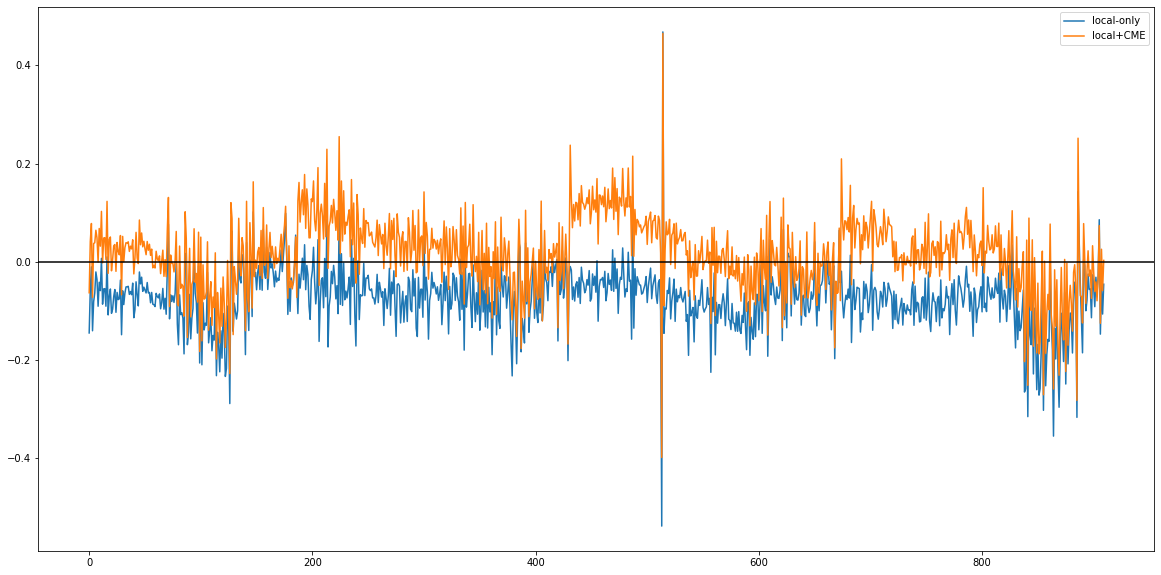

In [65]:
plt.plot(error, label="local-only")
plt.plot(error2, label='local+CME')
plt.legend()
plt.axhline(0, color='black')

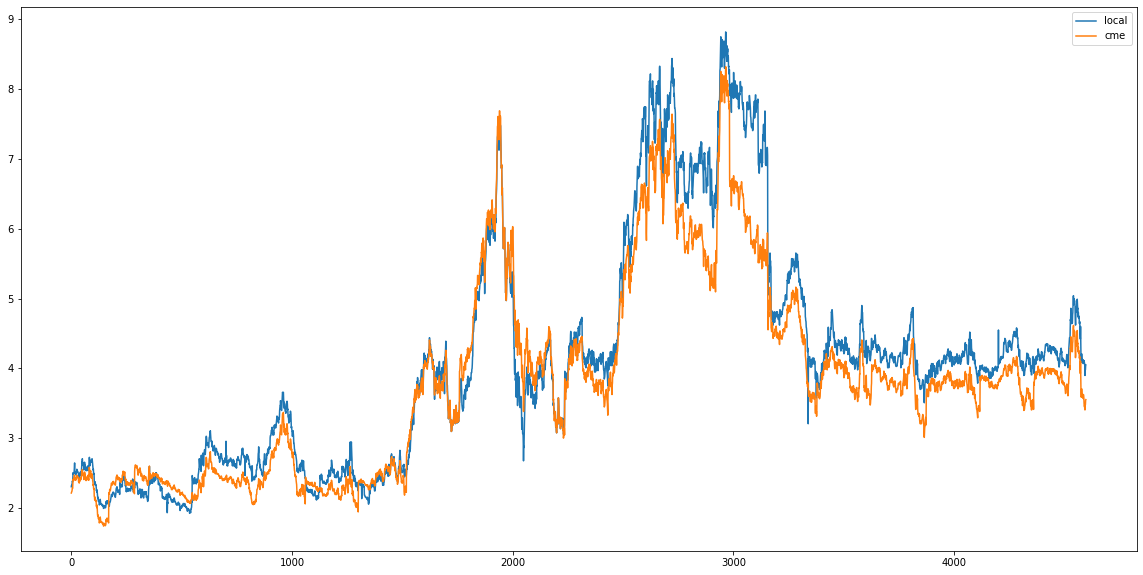

In [76]:
plt.plot(data['price'], label="local")
plt.plot(data['close'], label="cme")
plt.legend()

In [60]:
print("Price only")
print(pd.DataFrame(error).describe())
print("Price + future")
print(pd.DataFrame(error2).describe())

Price only
                0
count  910.000000
mean    -0.074275
std      0.063976
min     -0.539344
25%     -0.103304
50%     -0.069490
75%     -0.040506
max      0.468502
Price + future
                0
count  910.000000
mean     0.015909
std      0.078320
min     -0.399518
25%     -0.024981
50%      0.022184
75%      0.065170
max      0.465351
